In [251]:
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd
import data_extraction

import ARIMA
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [252]:
def ANN_train(X_train, y_train, hidden_layers, alpha=1e-5, random_state=1):
    '''
    INPUT:
    timeseries: TYPE: DataFrame. Contains column named 'residual'
    q: TYPE: Integer. Decides how many historical values to consider
    hidden_layers: TYPE: Tuple of integers. The number on the i'th position decides number of nodes in hidden layer i

    OUTPUT:
    Returns trained model: TYPE: MLPRegressor
    '''
    model = MLPRegressor(solver="adam", 
                         alpha=alpha, 
                         hidden_layer_sizes=hidden_layers, 
                         random_state=random_state, 
                         max_iter=20000,
                         learning_rate = "adaptive",
                         tol=1e-8) #default tolerance
    model.fit(X_train, y_train)
    return model

In [253]:
past_weeks = 4
hidden_layers = (3,3)
nRowsRead = None
grid_number = 1

df = pd.read_pickle('ARIMA_forecast.pkl')

def to_datetime(string):
    return datetime.strptime(string, "%Y-%m-%d %H:%M:%S")


def to_string(date):
    return datetime.strftime(date, "%Y-%m-%d %H:%M:%S")


In [254]:
df['residuals'].size

12902

In [255]:
def data_ANN(past_weeks, df):
    # input values
    # past_vals is the number of past values of the residuals that the ANN will use
    residuals = df["residuals"]

    X = []
    y = []
    
    for i in tqdm(range(len(residuals.values) - past_weeks*24*7)):
        X_el = residuals[i:i+24*7*past_weeks:24*7]
        X.append(X_el)
        y.append([residuals.iloc[i+past_weeks*24*7]])
    
    return X, y


In [256]:
X, y = data_ANN(past_weeks, df)

100%|██████████| 12230/12230 [00:01<00:00, 11341.88it/s]


In [257]:
train_size_percentage = 0.80

train_size = int(len(X)*train_size_percentage)
#print(len(data_extraction.get_timeseries("train", nRowsRead, 'loss', grid_number))/(24*7))

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [258]:
model = ANN_train(X_train, y_train, hidden_layers)

In [259]:
def ANN_pred(model, X_test,X,y):
    X_test = X_test.copy()
    y_test = []
    for i in tqdm(range(len(X_test))):
        X_test_el = X_test[i].values
        val = model.predict(X_test_el.reshape(1,-1))
        y_test.append(val[0])
        if i%23==0 and i < len(X_test)-24:
            model.partial_fit(X[train_size+i:train_size+i+24], y[train_size+i:train_size+i+24])
    return y_test



In [260]:
y_pred = ANN_pred(model, X_test,X,y)

100%|██████████| 2446/2446 [00:00<00:00, 3437.88it/s]


In [261]:
temp = df.copy()
temp['pred_residuals'] = np.nan
temp['pred_residuals'].iloc[-len(y_pred):] = y_pred
#(temp['residuals']-temp['pred_residuals']).dropna().hist()

<AxesSubplot:>

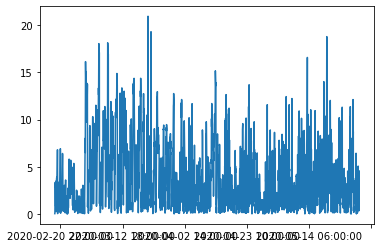

In [262]:
(abs(temp['residuals']-temp["pred_residuals"])).plot()

In [263]:
df_from_ANN = pd.read_pickle('ANN_alone_forecast.pkl')

In [264]:
df_from_ANN

,grid1-loss,pred,diff,ann_sum_error,ann_cumsum
2019-12-01 00:00:00,21.55210,22.686309,-1.134209,1.134209,1.134209
2019-12-01 01:00:00,20.71190,21.595508,-0.883608,0.883608,2.017817
2019-12-01 02:00:00,20.27340,20.773316,-0.499916,0.499916,2.517733
2019-12-01 03:00:00,20.25370,20.443139,-0.189439,0.189439,2.707172
2019-12-01 04:00:00,20.40550,20.209076,0.196424,0.196424,2.903596
...,...,...,...,...,...
2020-05-30 19:00:00,8.55980,13.035968,-4.476168,4.476168,22534.680531
2020-05-30 20:00:00,6.95209,12.870605,-5.918515,5.918515,22540.599047
2020-05-30 21:00:00,8.11558,12.926121,-4.810541,4.810541,22545.409588
2020-05-30 23:00:00,7.26431,12.561953,-5.297643,5.297643,22550.707231


In [265]:
temp = temp.dropna()

temp['Hybrid'] = temp['ARIMA']+temp['pred_residuals']
temp['ANN'] = df_from_ANN['pred']

temp['arima_sum_error'] = abs(temp['grid-loss'] - temp['ARIMA'])
temp['hybrid_sum_error'] = abs(temp['grid-loss'] - temp['Hybrid'])
temp['ann_sum_error'] = df_from_ANN['ann_sum_error']

temp['arima_cumsum'] = temp['arima_sum_error'].cumsum()
temp['hybrid_cumsum'] = temp['hybrid_sum_error'].cumsum()
temp['error_in_res'] = (temp['residuals']-temp['pred_residuals'])
temp['ann_cumsum'] = df_from_ANN['ann_sum_error'].iloc[-train_size:].cumsum()

In [266]:
temp['grid-loss'].min()
temp.index = [to_datetime(string) for string in temp.index]

<AxesSubplot:>

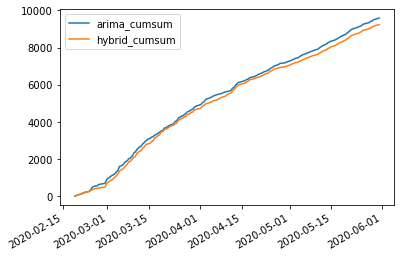

In [267]:
temp[['arima_cumsum','hybrid_cumsum']].iloc[:].plot()


In [268]:
(temp['arima_cumsum'].iloc[-1]-temp['hybrid_cumsum'].iloc[-1])/temp['arima_cumsum'].iloc[-1]

0.03679666037726442

In [269]:
diff = temp['grid-loss']-temp['Hybrid']
mse_hybrid = (diff**2).mean()

In [270]:
diff = temp['grid-loss']-temp['ARIMA']
mse_arima = (diff**2).mean()



In [271]:
(mse_arima-mse_hybrid)/mse_arima

0.06239177523213835

In [272]:
abs(temp['error_in_res']).cumsum()

2020-02-19 02:00:00       0.028162
2020-02-19 03:00:00       0.125621
2020-02-19 04:00:00       1.978883
2020-02-19 05:00:00       5.315533
2020-02-19 06:00:00       8.201148
                          ...     
2020-05-30 19:00:00    9229.181923
2020-05-30 20:00:00    9229.500543
2020-05-30 21:00:00    9230.321258
2020-05-30 23:00:00    9234.893317
2020-05-31 00:00:00    9236.665187
Name: error_in_res, Length: 2446, dtype: float64

<AxesSubplot:>

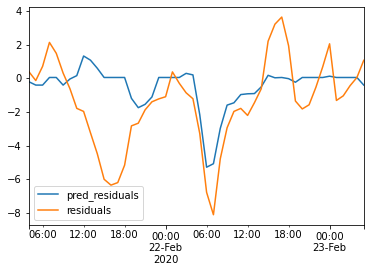

In [273]:
temp[['pred_residuals','residuals']].iloc[50:100].plot()

<AxesSubplot:>

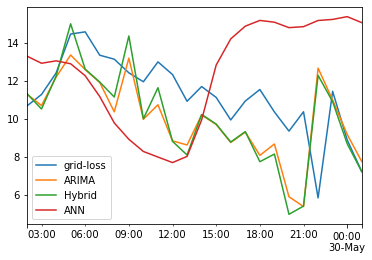

In [274]:
temp[['grid-loss','ARIMA', 'Hybrid', 'ANN']].iloc[2400:2424].plot()

In [275]:
mse = sum([temp['grid-loss']-temp['Hybrid']])

In [276]:
temp[['Hybrid', 'pred_residuals']].to_pickle('ANN_in_hybrid_forecast.pkl')

In [277]:
temp

,grid-loss,ARIMA,residuals,pred_residuals,Hybrid,ANN,arima_sum_error,hybrid_sum_error,ann_sum_error,arima_cumsum,hybrid_cumsum,error_in_res,ann_cumsum
2020-02-19 02:00:00,16.84450,16.761747,0.082753,0.054592,16.816338,29.209692,0.082753,0.028162,12.365192,0.082753,0.028162,0.028162,10875.806197
2020-02-19 03:00:00,16.90030,16.942131,-0.041831,0.055629,16.997759,29.503707,0.041831,0.097459,12.603407,0.124584,0.125621,-0.097459,10888.409604
2020-02-19 04:00:00,18.13120,18.627957,-0.496757,-2.350020,16.277938,29.295074,0.496757,1.853262,11.163874,0.621341,1.978883,1.853262,10899.573478
2020-02-19 05:00:00,22.22810,21.275257,0.952843,-2.383807,18.891450,28.609907,0.952843,3.336650,6.381807,1.574184,5.315533,3.336650,10905.955284
2020-02-19 06:00:00,27.60820,24.997764,2.610436,-0.275179,24.722585,27.528905,2.610436,2.885615,0.079295,4.184620,8.201148,2.885615,10906.034580
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-30 19:00:00,8.55980,7.129942,1.429858,-0.780193,6.349748,13.035968,1.429858,2.210052,4.476168,9582.394314,9229.181923,2.210052,22534.680531
2020-05-30 20:00:00,6.95209,6.751133,0.200957,-0.117663,6.633470,12.870605,0.200957,0.318620,5.918515,9582.595271,9229.500543,0.318620,22540.599047
2020-05-30 21:00:00,8.11558,8.986810,-0.871230,-1.691944,7.294865,12.926121,0.871230,0.820715,4.810541,9583.466500,9230.321258,0.820715,22545.409588
2020-05-30 23:00:00,7.26431,11.185511,-3.921201,0.650858,11.836369,12.561953,3.921201,4.572059,5.297643,9587.387701,9234.893317,-4.572059,22550.707231
